In [1]:
#IMPORTS

import numpy as np
import random
import tensorflow as tf
import tensorflow.keras as kr
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.datasets import mnist
import os
import csv

from scipy.spatial.distance import euclidean
from sklearn.metrics import confusion_matrix

from time import sleep
from tqdm import tqdm

import copy
import numpy
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from numpy.random import RandomState
import scipy as scp
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.utils import to_categorical
from keras import backend as K
from itertools import product
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn import mixture

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Enter here the data set you want to explain (adult, activity, or synthatic)

data_set = 'activity'

# Enter here the numb er of peers you want in the experiments

n_peers = 100

# Enter here the type of the attack (Byzantine, poisoning, label_flipping)
attack_type = 'Byzantine'

# the targeted features in case the attack is poisoning attack 
feature_attacked = [3,5,8]

# Enter here the number of attacker peers you want, keep the number of attacker less that 1/2 of the n_peers
number_attackers = 3

# enter here the Number of global training epochs, the start and ending epochs of the attacks
n_rounds = 10
start_attack_round = 3
end_attack_round = 7

# the threshold for attack detection

alpha = 1.2

beta = 1/4

In [3]:
# the random state we will use in the experiments. It can be changed 

rs = RandomState(92)

In [4]:
# preprocessing adults data set

if data_set == 'adult':
    #Load dataset into a pandas DataFrame
    adult_data = pd.read_csv('adult_data.csv', na_values='?')
    # Drop all records with missing values
    adult_data.dropna(inplace=True)
    adult_data.reset_index(drop=True, inplace=True)

    # Drop fnlwgt, not interesting for ML
    adult_data.drop('fnlwgt', axis=1, inplace=True)
    adult_data.drop('education', axis=1, inplace=True)

#     merging some similar features.
    adult_data['marital-status'].replace('Married-civ-spouse', 'Married', inplace=True)
    adult_data['marital-status'].replace('Divorced', 'Unmarried', inplace=True)
    adult_data['marital-status'].replace('Never-married', 'Unmarried', inplace=True)
    adult_data['marital-status'].replace('Separated', 'Unmarried', inplace=True)
    adult_data['marital-status'].replace('Widowed', 'Unmarried', inplace=True)
    adult_data['marital-status'].replace('Married-spouse-absent', 'Married', inplace=True)
    adult_data['marital-status'].replace('Married-AF-spouse', 'Married', inplace=True)
    
    adult_data = pd.concat([adult_data,pd.get_dummies(adult_data['income'], prefix='income')],axis=1)
    adult_data.drop('income', axis=1, inplace=True)
    obj_columns = adult_data.select_dtypes(['object']).columns
    adult_data[obj_columns] = adult_data[obj_columns].astype('category')
    # Convert numerics to floats and normalize
    num_columns = adult_data.select_dtypes(['int64']).columns
    adult_data[num_columns] = adult_data[num_columns].astype('float64')
    for c in num_columns:
        #adult[c] -= adult[c].mean()
        #adult[c] /= adult[c].std()
         adult_data[c] = (adult_data[c] - adult_data[c].min()) / (adult_data[c].max()-adult_data[c].min())
    # 'workclass', 'marital-status', 'occupation', 'relationship' ,'race', 'gender', 'native-country'
    # adult_data['income'] = adult_data['income'].cat.codes
    adult_data['marital-status'] = adult_data['marital-status'].cat.codes
    adult_data['occupation'] = adult_data['occupation'].cat.codes
    adult_data['relationship'] = adult_data['relationship'].cat.codes
    adult_data['race'] = adult_data['race'].cat.codes
    adult_data['gender'] = adult_data['gender'].cat.codes
    adult_data['native-country'] = adult_data['native-country'].cat.codes
    adult_data['workclass'] = adult_data['workclass'].cat.codes

    num_columns = adult_data.select_dtypes(['int8']).columns
    adult_data[num_columns] = adult_data[num_columns].astype('float64')
    for c in num_columns:
        #adult[c] -= adult[c].mean()
        #adult[c] /= adult[c].std()
         adult_data[c] = (adult_data[c] - adult_data[c].min()) / (adult_data[c].max()-adult_data[c].min())
    display(adult_data.info())
    display(adult_data.head(10))
    
    adult_data = adult_data.to_numpy()
    
#     splite the data to train and test datasets
    X_train, X_test, y_train, y_test = train_test_split(adult_data[:,:-2],adult_data[:,-2:], test_size=0.07, random_state=rs)
#     the names of the features
    names = ['age','workclass','educational-num','marital-status','occupation',
         'relationship','race','gender','capital-gain','capital-loss','hours-per-week','native-country']
    Features_number = len(X_train[0])

In [5]:
if data_set == 'synthatic':
    #generate the data
    X, y = make_classification(n_samples=1000000, n_features=10, n_redundant=3, n_repeated=2, #n_classes=3, 
                           n_informative=5, n_clusters_per_class=4, 
                           random_state=42)
    y = pd.DataFrame(data=y, columns=["y"])
    y = pd.get_dummies(y['y'], prefix='y')
    y = y.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.07, random_state=rs)
    #     the names of the features
    names = ['X(0)','X(1)','X(2)','X(3)','X(4)','X(5)','X(6)','X(7)','X(8)','X(9)']
    Features_number = len(X_train[0])

In [6]:
if data_set == 'activity':
    #Load dataset into a pandas DataFrame
    activity = pd.read_csv("activity_3_original.csv", sep=',')
#      drop some features that have non value in the majority of the samples
    to_drop = ['subject', 'timestamp', 'heart_rate','activityID']
    activity.drop(axis=1, columns=to_drop, inplace=True)
#     prepare the truth
    activity = pd.concat([activity,pd.get_dummies(activity['motion'], prefix='motion')],axis=1)
    activity.drop('motion', axis=1, inplace=True)
    class_label = [ 'motion_n', 'motion_y']
    predictors = [a for a in activity.columns.values if a not in class_label]

    for p in predictors:
        activity[p].fillna(activity[p].mean(), inplace=True)

    display(predictors)
    for p in predictors:
        activity[p] = (activity[p]-activity[p].min()) / (activity[p].max() - activity[p].min())
        activity[p].astype('float32')
    activity = activity.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(activity[:,:-2],activity[:,-2:], test_size=0.07, random_state=rs)
    #     the names of the features
    names = ['temp_hand','acceleration_16_x_hand',
        'acceleration_16_y_hand','acceleration_16_z_hand','acceleration_6_x_hand',
        'acceleration_6_y_hand','acceleration_6_z_hand','gyroscope_x_hand','gyroscope_y_hand',
        'gyroscope_z_hand','magnetometer_x_hand','magnetometer_y_hand','magnetometer_z_hand',
        'temp_chest','acceleration_16_x_chest','acceleration_16_y_chest','acceleration_16_z_chest','acceleration_6_x_chest',
        'acceleration_6_y_chest','acceleration_6_z_chest','gyroscope_x_chest','gyroscope_y_chest','gyroscope_z_chest',
        'magnetometer_x_chest','magnetometer_y_chest','magnetometer_z_chest','temp_ankle','acceleration_16_x_ankle',
        'acceleration_16_y_ankle','acceleration_16_z_ankle','acceleration_6_x_ankle','acceleration_6_y_ankle',
        'acceleration_6_z_ankle','gyroscope_x_ankle','gyroscope_y_ankle','gyroscope_z_ankle','magnetometer_x_ankle',
        'magnetometer_y_ankle','magnetometer_z_ankle']
    Features_number = len(X_train[0])


['temp_hand',
 'acceleration_16_x_hand',
 'acceleration_16_y_hand',
 'acceleration_16_z_hand',
 'acceleration_6_x_hand',
 'acceleration_6_y_hand',
 'acceleration_6_z_hand',
 'gyroscope_x_hand',
 'gyroscope_y_hand',
 'gyroscope_z_hand',
 'magnetometer_x_hand',
 'magnetometer_y_hand',
 'magnetometer_z_hand',
 'temp_chest',
 'acceleration_16_x_chest',
 'acceleration_16_y_chest',
 'acceleration_16_z_chest',
 'acceleration_6_x_chest',
 'acceleration_6_y_chest',
 'acceleration_6_z_chest',
 'gyroscope_x_chest',
 'gyroscope_y_chest',
 'gyroscope_z_chest',
 'magnetometer_x_chest',
 'magnetometer_y_chest',
 'magnetometer_z_chest',
 'temp_ankle',
 'acceleration_16_x_ankle',
 'acceleration_16_y_ankle',
 'acceleration_16_z_ankle',
 'acceleration_6_x_ankle',
 'acceleration_6_y_ankle',
 'acceleration_6_z_ankle',
 'gyroscope_x_ankle',
 'gyroscope_y_ankle',
 'gyroscope_z_ankle',
 'magnetometer_x_ankle',
 'magnetometer_y_ankle',
 'magnetometer_z_ankle']

In [7]:
#begin federated

earlystopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0.01,
                              patience = 50,
                              verbose = 0,
                              baseline = 2,
                              restore_best_weights = True)

checkpoint = ModelCheckpoint('test.h8',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=0)
    
model = Sequential()
model.add(Dense(70, input_dim=Features_number, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
history = model.fit(X_train, y_train,
epochs=2,
validation_data=(X_test, y_test),
callbacks = [checkpoint, earlystopping],
shuffle=True)

Train on 1806870 samples, validate on 136002 samples
Epoch 1/2


 225888/1806870 [==>...........................] - ETA: 3:38:09 - loss: 0.6677 - accuracy: 0.718 - ETA: 6:38 - loss: 0.6753 - accuracy: 0.5789  - ETA: 4:21 - loss: 0.6609 - accuracy: 0.58 - ETA: 3:24 - loss: 0.6429 - accuracy: 0.61 - ETA: 2:57 - loss: 0.6137 - accuracy: 0.64 - ETA: 2:38 - loss: 0.5775 - accuracy: 0.68 - ETA: 2:22 - loss: 0.5492 - accuracy: 0.70 - ETA: 2:10 - loss: 0.5185 - accuracy: 0.72 - ETA: 2:04 - loss: 0.4951 - accuracy: 0.74 - ETA: 1:58 - loss: 0.4725 - accuracy: 0.76 - ETA: 1:52 - loss: 0.4519 - accuracy: 0.77 - ETA: 1:48 - loss: 0.4357 - accuracy: 0.78 - ETA: 1:46 - loss: 0.4264 - accuracy: 0.79 - ETA: 1:42 - loss: 0.4195 - accuracy: 0.79 - ETA: 1:42 - loss: 0.4110 - accuracy: 0.80 - ETA: 1:39 - loss: 0.4011 - accuracy: 0.80 - ETA: 1:38 - loss: 0.3931 - accuracy: 0.81 - ETA: 1:36 - loss: 0.3829 - accuracy: 0.82 - ETA: 1:34 - loss: 0.3757 - accuracy: 0.82 - ETA: 1:32 - loss: 0.3680 - accuracy: 0.82 - ETA: 1:31 - loss: 0.3609 - accuracy: 0.83 - ETA: 1:30 - loss: 

 466080/1806870 [======>.......................] - ETA: 1:07 - loss: 0.1747 - accuracy: 0.93 - ETA: 1:07 - loss: 0.1745 - accuracy: 0.93 - ETA: 1:07 - loss: 0.1744 - accuracy: 0.93 - ETA: 1:07 - loss: 0.1740 - accuracy: 0.93 - ETA: 1:06 - loss: 0.1735 - accuracy: 0.93 - ETA: 1:06 - loss: 0.1733 - accuracy: 0.93 - ETA: 1:06 - loss: 0.1731 - accuracy: 0.93 - ETA: 1:06 - loss: 0.1727 - accuracy: 0.93 - ETA: 1:06 - loss: 0.1721 - accuracy: 0.93 - ETA: 1:06 - loss: 0.1717 - accuracy: 0.93 - ETA: 1:05 - loss: 0.1713 - accuracy: 0.93 - ETA: 1:05 - loss: 0.1709 - accuracy: 0.93 - ETA: 1:05 - loss: 0.1707 - accuracy: 0.93 - ETA: 1:05 - loss: 0.1705 - accuracy: 0.93 - ETA: 1:06 - loss: 0.1702 - accuracy: 0.93 - ETA: 1:06 - loss: 0.1699 - accuracy: 0.93 - ETA: 1:06 - loss: 0.1698 - accuracy: 0.93 - ETA: 1:06 - loss: 0.1695 - accuracy: 0.93 - ETA: 1:06 - loss: 0.1694 - accuracy: 0.93 - ETA: 1:06 - loss: 0.1693 - accuracy: 0.93 - ETA: 1:06 - loss: 0.1690 - accuracy: 0.93 - ETA: 1:06 - loss: 0.1687 

 743456/1806870 [===========>..................] - ETA: 54s - loss: 0.1345 - accuracy: 0.948 - ETA: 54s - loss: 0.1343 - accuracy: 0.948 - ETA: 54s - loss: 0.1342 - accuracy: 0.948 - ETA: 54s - loss: 0.1340 - accuracy: 0.949 - ETA: 54s - loss: 0.1338 - accuracy: 0.949 - ETA: 54s - loss: 0.1337 - accuracy: 0.949 - ETA: 54s - loss: 0.1334 - accuracy: 0.949 - ETA: 54s - loss: 0.1333 - accuracy: 0.949 - ETA: 54s - loss: 0.1331 - accuracy: 0.949 - ETA: 54s - loss: 0.1329 - accuracy: 0.949 - ETA: 54s - loss: 0.1327 - accuracy: 0.949 - ETA: 53s - loss: 0.1324 - accuracy: 0.949 - ETA: 53s - loss: 0.1323 - accuracy: 0.949 - ETA: 53s - loss: 0.1323 - accuracy: 0.949 - ETA: 53s - loss: 0.1321 - accuracy: 0.949 - ETA: 53s - loss: 0.1320 - accuracy: 0.949 - ETA: 53s - loss: 0.1318 - accuracy: 0.949 - ETA: 53s - loss: 0.1317 - accuracy: 0.950 - ETA: 53s - loss: 0.1315 - accuracy: 0.950 - ETA: 53s - loss: 0.1313 - accuracy: 0.950 - ETA: 53s - loss: 0.1311 - accuracy: 0.950 - ETA: 53s - loss: 0.1310 -

1020928/1806870 [===============>..............] - ETA: 40s - loss: 0.1083 - accuracy: 0.959 - ETA: 40s - loss: 0.1082 - accuracy: 0.959 - ETA: 40s - loss: 0.1080 - accuracy: 0.959 - ETA: 40s - loss: 0.1079 - accuracy: 0.959 - ETA: 40s - loss: 0.1077 - accuracy: 0.959 - ETA: 40s - loss: 0.1076 - accuracy: 0.959 - ETA: 40s - loss: 0.1075 - accuracy: 0.959 - ETA: 40s - loss: 0.1074 - accuracy: 0.960 - ETA: 40s - loss: 0.1073 - accuracy: 0.960 - ETA: 40s - loss: 0.1072 - accuracy: 0.960 - ETA: 39s - loss: 0.1071 - accuracy: 0.960 - ETA: 39s - loss: 0.1070 - accuracy: 0.960 - ETA: 39s - loss: 0.1069 - accuracy: 0.960 - ETA: 39s - loss: 0.1068 - accuracy: 0.960 - ETA: 39s - loss: 0.1067 - accuracy: 0.960 - ETA: 39s - loss: 0.1068 - accuracy: 0.960 - ETA: 39s - loss: 0.1067 - accuracy: 0.960 - ETA: 39s - loss: 0.1066 - accuracy: 0.960 - ETA: 39s - loss: 0.1066 - accuracy: 0.960 - ETA: 39s - loss: 0.1065 - accuracy: 0.960 - ETA: 39s - loss: 0.1064 - accuracy: 0.960 - ETA: 39s - loss: 0.1063 -

1303488/1806870 [====================>.........] - ETA: 29s - loss: 0.0921 - accuracy: 0.966 - ETA: 29s - loss: 0.0921 - accuracy: 0.966 - ETA: 29s - loss: 0.0920 - accuracy: 0.966 - ETA: 29s - loss: 0.0919 - accuracy: 0.966 - ETA: 29s - loss: 0.0919 - accuracy: 0.966 - ETA: 29s - loss: 0.0918 - accuracy: 0.966 - ETA: 28s - loss: 0.0918 - accuracy: 0.966 - ETA: 28s - loss: 0.0917 - accuracy: 0.966 - ETA: 28s - loss: 0.0917 - accuracy: 0.966 - ETA: 28s - loss: 0.0916 - accuracy: 0.966 - ETA: 28s - loss: 0.0915 - accuracy: 0.966 - ETA: 28s - loss: 0.0915 - accuracy: 0.966 - ETA: 28s - loss: 0.0914 - accuracy: 0.966 - ETA: 28s - loss: 0.0913 - accuracy: 0.966 - ETA: 28s - loss: 0.0912 - accuracy: 0.966 - ETA: 28s - loss: 0.0912 - accuracy: 0.966 - ETA: 28s - loss: 0.0911 - accuracy: 0.966 - ETA: 28s - loss: 0.0910 - accuracy: 0.966 - ETA: 28s - loss: 0.0909 - accuracy: 0.966 - ETA: 28s - loss: 0.0909 - accuracy: 0.966 - ETA: 28s - loss: 0.0908 - accuracy: 0.966 - ETA: 28s - loss: 0.0908 -

1592480/1806870 [=========================>....] - ETA: 18s - loss: 0.0808 - accuracy: 0.970 - ETA: 18s - loss: 0.0808 - accuracy: 0.970 - ETA: 18s - loss: 0.0807 - accuracy: 0.970 - ETA: 18s - loss: 0.0807 - accuracy: 0.970 - ETA: 18s - loss: 0.0806 - accuracy: 0.970 - ETA: 18s - loss: 0.0806 - accuracy: 0.970 - ETA: 17s - loss: 0.0805 - accuracy: 0.970 - ETA: 17s - loss: 0.0804 - accuracy: 0.970 - ETA: 17s - loss: 0.0804 - accuracy: 0.970 - ETA: 17s - loss: 0.0803 - accuracy: 0.970 - ETA: 17s - loss: 0.0802 - accuracy: 0.970 - ETA: 17s - loss: 0.0802 - accuracy: 0.970 - ETA: 17s - loss: 0.0802 - accuracy: 0.970 - ETA: 17s - loss: 0.0802 - accuracy: 0.970 - ETA: 17s - loss: 0.0801 - accuracy: 0.970 - ETA: 17s - loss: 0.0801 - accuracy: 0.970 - ETA: 17s - loss: 0.0800 - accuracy: 0.970 - ETA: 17s - loss: 0.0799 - accuracy: 0.970 - ETA: 17s - loss: 0.0799 - accuracy: 0.970 - ETA: 17s - loss: 0.0798 - accuracy: 0.970 - ETA: 17s - loss: 0.0798 - accuracy: 0.970 - ETA: 17s - loss: 0.0797 -

1806870/1806870 [==============================] - ETA: 7s - loss: 0.0723 - accuracy: 0.97 - ETA: 7s - loss: 0.0722 - accuracy: 0.97 - ETA: 7s - loss: 0.0722 - accuracy: 0.97 - ETA: 7s - loss: 0.0722 - accuracy: 0.97 - ETA: 7s - loss: 0.0722 - accuracy: 0.97 - ETA: 7s - loss: 0.0721 - accuracy: 0.97 - ETA: 7s - loss: 0.0721 - accuracy: 0.97 - ETA: 7s - loss: 0.0720 - accuracy: 0.97 - ETA: 7s - loss: 0.0720 - accuracy: 0.97 - ETA: 7s - loss: 0.0719 - accuracy: 0.97 - ETA: 7s - loss: 0.0719 - accuracy: 0.97 - ETA: 7s - loss: 0.0718 - accuracy: 0.97 - ETA: 6s - loss: 0.0718 - accuracy: 0.97 - ETA: 6s - loss: 0.0717 - accuracy: 0.97 - ETA: 6s - loss: 0.0717 - accuracy: 0.97 - ETA: 6s - loss: 0.0717 - accuracy: 0.97 - ETA: 6s - loss: 0.0716 - accuracy: 0.97 - ETA: 6s - loss: 0.0716 - accuracy: 0.97 - ETA: 6s - loss: 0.0715 - accuracy: 0.97 - ETA: 6s - loss: 0.0715 - accuracy: 0.97 - ETA: 6s - loss: 0.0715 - accuracy: 0.97 - ETA: 6s - loss: 0.0714 - accuracy: 0.97 - ETA: 6s - loss: 0.0714 - 

 255680/1806870 [===>..........................] - ETA: 1:52:37 - loss: 0.0028 - accuracy: 1.000 - ETA: 4:13 - loss: 0.0256 - accuracy: 0.9901  - ETA: 2:40 - loss: 0.0382 - accuracy: 0.98 - ETA: 2:10 - loss: 0.0324 - accuracy: 0.99 - ETA: 1:57 - loss: 0.0302 - accuracy: 0.99 - ETA: 1:47 - loss: 0.0321 - accuracy: 0.98 - ETA: 1:41 - loss: 0.0311 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0318 - accuracy: 0.98 - ETA: 1:34 - loss: 0.0307 - accuracy: 0.98 - ETA: 1:34 - loss: 0.0307 - accuracy: 0.98 - ETA: 1:33 - loss: 0.0352 - accuracy: 0.98 - ETA: 1:32 - loss: 0.0353 - accuracy: 0.98 - ETA: 1:32 - loss: 0.0343 - accuracy: 0.98 - ETA: 1:31 - loss: 0.0347 - accuracy: 0.98 - ETA: 1:29 - loss: 0.0354 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0349 - accuracy: 0.98 - ETA: 1:26 - loss: 0.0345 - accuracy: 0.98 - ETA: 1:25 - loss: 0.0337 - accuracy: 0.98 - ETA: 1:23 - loss: 0.0336 - accuracy: 0.98 - ETA: 1:22 - loss: 0.0330 - accuracy: 0.98 - ETA: 1:22 - loss: 0.0331 - accuracy: 0.98 - ETA: 1:23 - loss: 

 545536/1806870 [========>.....................] - ETA: 57s - loss: 0.0274 - accuracy: 0.990 - ETA: 57s - loss: 0.0273 - accuracy: 0.990 - ETA: 57s - loss: 0.0273 - accuracy: 0.990 - ETA: 57s - loss: 0.0273 - accuracy: 0.990 - ETA: 57s - loss: 0.0273 - accuracy: 0.990 - ETA: 57s - loss: 0.0274 - accuracy: 0.990 - ETA: 57s - loss: 0.0274 - accuracy: 0.990 - ETA: 56s - loss: 0.0272 - accuracy: 0.990 - ETA: 56s - loss: 0.0272 - accuracy: 0.990 - ETA: 56s - loss: 0.0272 - accuracy: 0.990 - ETA: 56s - loss: 0.0272 - accuracy: 0.990 - ETA: 56s - loss: 0.0272 - accuracy: 0.990 - ETA: 56s - loss: 0.0272 - accuracy: 0.990 - ETA: 56s - loss: 0.0272 - accuracy: 0.990 - ETA: 56s - loss: 0.0271 - accuracy: 0.990 - ETA: 56s - loss: 0.0271 - accuracy: 0.990 - ETA: 55s - loss: 0.0271 - accuracy: 0.990 - ETA: 55s - loss: 0.0271 - accuracy: 0.990 - ETA: 55s - loss: 0.0271 - accuracy: 0.990 - ETA: 55s - loss: 0.0271 - accuracy: 0.990 - ETA: 55s - loss: 0.0271 - accuracy: 0.990 - ETA: 55s - loss: 0.0271 -

 827360/1806870 [============>.................] - ETA: 43s - loss: 0.0266 - accuracy: 0.991 - ETA: 43s - loss: 0.0266 - accuracy: 0.991 - ETA: 43s - loss: 0.0265 - accuracy: 0.991 - ETA: 43s - loss: 0.0265 - accuracy: 0.991 - ETA: 43s - loss: 0.0264 - accuracy: 0.991 - ETA: 43s - loss: 0.0264 - accuracy: 0.991 - ETA: 43s - loss: 0.0264 - accuracy: 0.991 - ETA: 43s - loss: 0.0264 - accuracy: 0.991 - ETA: 43s - loss: 0.0264 - accuracy: 0.991 - ETA: 43s - loss: 0.0264 - accuracy: 0.991 - ETA: 43s - loss: 0.0264 - accuracy: 0.991 - ETA: 43s - loss: 0.0264 - accuracy: 0.991 - ETA: 43s - loss: 0.0264 - accuracy: 0.991 - ETA: 43s - loss: 0.0264 - accuracy: 0.991 - ETA: 42s - loss: 0.0264 - accuracy: 0.991 - ETA: 42s - loss: 0.0263 - accuracy: 0.991 - ETA: 42s - loss: 0.0263 - accuracy: 0.991 - ETA: 42s - loss: 0.0263 - accuracy: 0.991 - ETA: 42s - loss: 0.0263 - accuracy: 0.991 - ETA: 42s - loss: 0.0263 - accuracy: 0.991 - ETA: 42s - loss: 0.0263 - accuracy: 0.991 - ETA: 42s - loss: 0.0263 -

1088864/1806870 [=================>............] - ETA: 33s - loss: 0.0251 - accuracy: 0.991 - ETA: 33s - loss: 0.0251 - accuracy: 0.991 - ETA: 33s - loss: 0.0251 - accuracy: 0.991 - ETA: 33s - loss: 0.0251 - accuracy: 0.991 - ETA: 33s - loss: 0.0251 - accuracy: 0.991 - ETA: 33s - loss: 0.0251 - accuracy: 0.991 - ETA: 33s - loss: 0.0250 - accuracy: 0.991 - ETA: 33s - loss: 0.0250 - accuracy: 0.991 - ETA: 33s - loss: 0.0250 - accuracy: 0.991 - ETA: 33s - loss: 0.0250 - accuracy: 0.991 - ETA: 33s - loss: 0.0250 - accuracy: 0.991 - ETA: 33s - loss: 0.0250 - accuracy: 0.991 - ETA: 33s - loss: 0.0249 - accuracy: 0.991 - ETA: 33s - loss: 0.0249 - accuracy: 0.991 - ETA: 32s - loss: 0.0249 - accuracy: 0.991 - ETA: 32s - loss: 0.0249 - accuracy: 0.991 - ETA: 32s - loss: 0.0249 - accuracy: 0.991 - ETA: 32s - loss: 0.0249 - accuracy: 0.991 - ETA: 32s - loss: 0.0249 - accuracy: 0.991 - ETA: 32s - loss: 0.0249 - accuracy: 0.991 - ETA: 32s - loss: 0.0249 - accuracy: 0.991 - ETA: 32s - loss: 0.0249 -

1370528/1806870 [=====================>........] - ETA: 24s - loss: 0.0240 - accuracy: 0.992 - ETA: 24s - loss: 0.0240 - accuracy: 0.992 - ETA: 24s - loss: 0.0240 - accuracy: 0.992 - ETA: 24s - loss: 0.0240 - accuracy: 0.992 - ETA: 24s - loss: 0.0240 - accuracy: 0.992 - ETA: 24s - loss: 0.0240 - accuracy: 0.992 - ETA: 24s - loss: 0.0240 - accuracy: 0.992 - ETA: 24s - loss: 0.0239 - accuracy: 0.992 - ETA: 24s - loss: 0.0239 - accuracy: 0.992 - ETA: 24s - loss: 0.0240 - accuracy: 0.992 - ETA: 24s - loss: 0.0240 - accuracy: 0.992 - ETA: 24s - loss: 0.0240 - accuracy: 0.992 - ETA: 24s - loss: 0.0240 - accuracy: 0.992 - ETA: 24s - loss: 0.0240 - accuracy: 0.992 - ETA: 24s - loss: 0.0240 - accuracy: 0.992 - ETA: 24s - loss: 0.0240 - accuracy: 0.992 - ETA: 24s - loss: 0.0239 - accuracy: 0.992 - ETA: 24s - loss: 0.0239 - accuracy: 0.992 - ETA: 24s - loss: 0.0239 - accuracy: 0.992 - ETA: 23s - loss: 0.0239 - accuracy: 0.992 - ETA: 23s - loss: 0.0239 - accuracy: 0.992 - ETA: 23s - loss: 0.0239 -

1661024/1806870 [==========================>...] - ETA: 15s - loss: 0.0229 - accuracy: 0.992 - ETA: 14s - loss: 0.0229 - accuracy: 0.992 - ETA: 14s - loss: 0.0229 - accuracy: 0.992 - ETA: 14s - loss: 0.0229 - accuracy: 0.992 - ETA: 14s - loss: 0.0229 - accuracy: 0.992 - ETA: 14s - loss: 0.0229 - accuracy: 0.992 - ETA: 14s - loss: 0.0229 - accuracy: 0.992 - ETA: 14s - loss: 0.0229 - accuracy: 0.992 - ETA: 14s - loss: 0.0229 - accuracy: 0.992 - ETA: 14s - loss: 0.0229 - accuracy: 0.992 - ETA: 14s - loss: 0.0229 - accuracy: 0.992 - ETA: 14s - loss: 0.0229 - accuracy: 0.992 - ETA: 14s - loss: 0.0229 - accuracy: 0.992 - ETA: 14s - loss: 0.0228 - accuracy: 0.992 - ETA: 14s - loss: 0.0228 - accuracy: 0.992 - ETA: 14s - loss: 0.0228 - accuracy: 0.992 - ETA: 14s - loss: 0.0228 - accuracy: 0.992 - ETA: 14s - loss: 0.0228 - accuracy: 0.992 - ETA: 14s - loss: 0.0228 - accuracy: 0.992 - ETA: 13s - loss: 0.0228 - accuracy: 0.992 - ETA: 13s - loss: 0.0228 - accuracy: 0.992 - ETA: 13s - loss: 0.0228 -

1806870/1806870 [==============================] - ETA: 4s - loss: 0.0220 - accuracy: 0.99 - ETA: 4s - loss: 0.0220 - accuracy: 0.99 - ETA: 4s - loss: 0.0220 - accuracy: 0.99 - ETA: 4s - loss: 0.0220 - accuracy: 0.99 - ETA: 4s - loss: 0.0220 - accuracy: 0.99 - ETA: 4s - loss: 0.0220 - accuracy: 0.99 - ETA: 4s - loss: 0.0220 - accuracy: 0.99 - ETA: 4s - loss: 0.0220 - accuracy: 0.99 - ETA: 4s - loss: 0.0220 - accuracy: 0.99 - ETA: 4s - loss: 0.0220 - accuracy: 0.99 - ETA: 4s - loss: 0.0219 - accuracy: 0.99 - ETA: 4s - loss: 0.0219 - accuracy: 0.99 - ETA: 4s - loss: 0.0219 - accuracy: 0.99 - ETA: 4s - loss: 0.0220 - accuracy: 0.99 - ETA: 4s - loss: 0.0220 - accuracy: 0.99 - ETA: 4s - loss: 0.0220 - accuracy: 0.99 - ETA: 4s - loss: 0.0220 - accuracy: 0.99 - ETA: 4s - loss: 0.0220 - accuracy: 0.99 - ETA: 4s - loss: 0.0219 - accuracy: 0.99 - ETA: 4s - loss: 0.0219 - accuracy: 0.99 - ETA: 3s - loss: 0.0219 - accuracy: 0.99 - ETA: 3s - loss: 0.0219 - accuracy: 0.99 - ETA: 3s - loss: 0.0219 - 

In [8]:
#AUXILIARY METHODS FOR FEDERATED LEARNING

# RETURN INDICES TO LAYERS WITH WEIGHTS AND BIASES
def trainable_layers(model):
    return [i for i, layer in enumerate(model.layers) if len(layer.get_weights()) > 0]

# RETURN WEIGHTS AND BIASES OF A MODEL
def get_parameters(model):
    weights = []
    biases = []
    index = trainable_layers(model)
    for i in index:
        weights.append(copy.deepcopy(model.layers[i].get_weights()[0]))
        biases.append(copy.deepcopy(model.layers[i].get_weights()[1]))           
    
    return weights, biases
        
# SET WEIGHTS AND BIASES OF A MODEL
def set_parameters(model, weights, biases):
    index = trainable_layers(model)
    for i, j in enumerate(index):
        model.layers[j].set_weights([weights[i], biases[i]])
    
# DEPRECATED: RETURN THE GRADIENTS OF THE MODEL AFTER AN UPDATE 
def get_gradients(model, inputs, outputs):
    """ Gets gradient of model for given inputs and outputs for all weights"""
    grads = model.optimizer.get_gradients(model.total_loss, model.trainable_weights)
    symb_inputs = (model._feed_inputs + model._feed_targets + model._feed_sample_weights)
    f = K.function(symb_inputs, grads)
    x, y, sample_weight = model._standardize_user_data(inputs, outputs)
    output_grad = f(x + y + sample_weight)
    
    w_grad = [w for i,w in enumerate(output_grad) if i%2==0]
    b_grad = [w for i,w in enumerate(output_grad) if i%2==1]
    
    return w_grad, b_grad

# RETURN THE DIFFERENCE OF MODELS' WEIGHTS AND BIASES AFTER AN UPDATE 
# NOTE: LEARNING RATE IS APPLIED, SO THE UPDATE IS DIFFERENT FROM THE
# GRADIENTS. IN CASE VANILLA SGD IS USED, THE GRADIENTS ARE OBTAINED
# AS (UPDATES / LEARNING_RATE)
def get_updates(model, inputs, outputs, batch_size, epochs):
    w, b = get_parameters(model)
    #model.train_on_batch(inputs, outputs)
    model.fit(inputs, outputs, batch_size=batch_size, epochs=epochs, verbose=0)
    w_new, b_new = get_parameters(model)
    
    weight_updates = [old - new for old,new in zip(w, w_new)]
    bias_updates = [old - new for old,new in zip(b, b_new)]
    
    return weight_updates, bias_updates

# UPDATE THE MODEL'S WEIGHTS AND PARAMETERS WITH AN UPDATE
def apply_updates(model, eta, w_new, b_new):
    w, b = get_parameters(model)
    new_weights = [theta - eta*delta for theta,delta in zip(w, w_new)]
    new_biases = [theta - eta*delta for theta,delta in zip(b, b_new)]
    set_parameters(model, new_weights, new_biases)
    
# FEDERATED AGGREGATION FUNCTION
def aggregate(n_layers, n_peers, f, w_updates, b_updates):
    agg_w = [f([w_updates[j][i] for j in range(n_peers)], axis=0) for i in range(n_layers)]
    agg_b = [f([b_updates[j][i] for j in range(n_peers)], axis=0) for i in range(n_layers)]
    return agg_w, agg_b

# SOLVE NANS
def nans_to_zero(W, B):
    W0 = [np.nan_to_num(w, nan=0.0, posinf=0.0, neginf=0.0) for w in W]
    B0 = [np.nan_to_num(b, nan=0.0, posinf=0.0, neginf=0.0) for b in B]
    return W0, B0

def build_forest(X,y):
    clf=RandomForestClassifier(n_estimators=1000, max_depth=7, random_state=0, verbose = 1)
    clf.fit(X,y)
    return clf

# COMPUTE EUCLIDEAN DISTANCE OF WEIGHTS
def dist_weights(w_a, w_b):
    wf_a = flatten_weights(w_a)
    wf_b = flatten_weights(w_b)
    return euclidean(wf_a, wf_b)

# TRANSFORM ALL WEIGHT TENSORS TO 1D ARRAY
def flatten_weights(w_in):
    h = w_in[0].reshape(-1)
    for w in w_in[1:]:
        h = np.append(h, w.reshape(-1))
    return h
    

In [9]:
def byzantine_attack_data(inputs):
    attack_persentage = 40
    number_of_attacked_samples = len(inputs) * attack_persentage /100
    number_of_attacked_samples = int(number_of_attacked_samples)
    sampels_attacked =  random.sample(range(len(inputs)), number_of_attacked_samples)
    if data_set == 'adult':
        z=0
        C=0
        z=inputs.max(axis = 0)
        C=inputs.min(axis = 0)
        for i in range(len(inputs)):
            if i in sampels_attacked:
                for j in range(len(inputs[0])):
                    inputs[i][j]= random.uniform(z[j], C[j])
    return inputs

In [10]:
def poisoning_attack_data(h, feature_attacked):
    attack_persentage = 60
    number_of_attacked_samples = len(h) * attack_persentage /100
    number_of_attacked_samples = int(number_of_attacked_samples)
    sampels_attacked =  random.sample(range(len(h)), number_of_attacked_samples)
    if data_set == 'adult':
        z=0
        C=0
        z=h.max(axis = 0)
        C=h.min(axis = 0)
        for i in range(len(h)):
            if i in sampels_attacked:
                for j in range(len(feature_attacked)):
                    h[i][feature_attacked[j]]= random.uniform(z[feature_attacked[j]], C[feature_attacked[j]])
    return h

In [11]:
def label_flipping_attack_data(z):
    attack_persentage = 50
    number_of_attacked_samples = len(z) * attack_persentage /100
    number_of_attacked_samples = int(number_of_attacked_samples)
    sampels_attacked =  random.sample(range(len(z)), number_of_attacked_samples)
    if data_set == 'adult':
        for i in range(len(z)):
            if i in sampels_attacked:
                for j in range(len(z[i])):
                    if z[i][j] == 0:
                        z[i][j] = 1
                    else:
                        z[i][j] = 0
                    
    return z

In [12]:
# scan the forest for trees maches the wrong predictions of the black-box
def scan_wrong(forest_predictions, FL_predict1, forest , y_test_local, X_test_local):
    sum_feature_improtance= 0
    overal_wrong_feature_importance = 0
    counter = 0
    second_counter = 0
    never_seen = 0
    avr_wrong_importance = 0
    FL_predict1 = np.argmax(FL_predict1, axis=1)
    forest_predictions = np.argmax(forest_predictions, axis=1)
    y_test_local = np.argmax(y_test_local, axis=1)
    FL_wrong = 0
    for i in range (len(FL_predict1)):
        i_tree = 0
#         if the black-box got a wrong prediction
        if (FL_predict1[i] != y_test_local[i]):
            FL_wrong = FL_wrong + 1
#         getting the prediction of the trees one by one
            for tree_in_forest in forest.estimators_:
                sample = X_test_local[i].reshape(1, -1)
                temp = forest.estimators_[i_tree].predict(sample)
                temp =  np.argmax(temp, axis=1)
#                 print('the prediction of the t')
#                 print(temp)
                i_tree = i_tree + 1
#  if the prediction of the tree maches the predictions of the black-box
                if(FL_predict1[i] == temp):
#         getting the features importances
                    sum_feature_improtance = sum_feature_improtance + tree_in_forest.feature_importances_
                    counter = counter + 1
#         if we have trees maches the black-box predictions
        if(counter>0):
            ave_feature_importence = sum_feature_improtance/counter
            overal_wrong_feature_importance = ave_feature_importence + overal_wrong_feature_importance
            second_counter = second_counter + 1
            counter = 0
            sum_feature_improtance = 0
#             if there is no trees maches the black-box predictions
        else:
            if(FL_predict1[i] != y_test_local[i]):
                never_seen = never_seen +1

#                 getting the average features importances for all the samples that had wrong predictions.
    if(second_counter>0):
        avr_wrong_importance = overal_wrong_feature_importance / second_counter
    return avr_wrong_importance

In [13]:
trainable_layers(model)

[0, 1, 2, 3]

In [14]:
get_parameters(model)

([array([[ 0.08338594, -0.1254255 , -0.49211267, ...,  0.24750227,
          -0.65377104, -0.05224424],
         [-0.01734522, -0.1021487 ,  0.14053608, ..., -0.28375858,
          -0.15333907, -0.21018188],
         [ 0.0459124 ,  0.17106615, -0.2748136 , ...,  0.29032764,
          -0.12925142,  0.06985184],
         ...,
         [-0.15448453,  0.17909111,  0.18795453, ...,  0.46541557,
           0.01830631, -0.0534319 ],
         [-0.15942477,  0.09147607,  0.06007228, ...,  0.11995307,
           0.5220185 , -0.16314192],
         [ 0.09670959, -0.1825741 , -0.24682267, ...,  0.21973692,
           0.26263914,  0.1036981 ]], dtype=float32),
  array([[-0.13370994,  0.05705584, -0.01060855, ...,  0.03942909,
          -0.05360872,  0.18457419],
         [ 0.18660966,  0.02259383, -0.06519584, ...,  0.12901685,
          -0.03150385, -0.05975418],
         [-0.18495369, -0.3026115 ,  0.15492044, ...,  0.3693038 ,
           0.42332208,  0.17241667],
         ...,
         [-0.414822

In [15]:
get_updates(model, X_train, y_train, 32, 2)

([array([[ 2.8014183e-06,  0.0000000e+00, -4.5895576e-06, ...,
          -2.2205949e-02,  0.0000000e+00,  0.0000000e+00],
         [ 2.1923333e-06,  0.0000000e+00, -7.8976154e-06, ...,
           4.9105823e-02,  0.0000000e+00,  0.0000000e+00],
         [ 1.5608966e-06,  0.0000000e+00, -3.7252903e-06, ...,
           7.3180795e-03,  0.0000000e+00,  0.0000000e+00],
         ...,
         [ 1.5050173e-06,  0.0000000e+00, -7.4207783e-06, ...,
          -2.6787940e-01,  0.0000000e+00,  0.0000000e+00],
         [ 1.8626451e-06,  0.0000000e+00, -8.1695616e-06, ...,
           1.6834244e-02,  0.0000000e+00,  0.0000000e+00],
         [ 1.7285347e-06,  0.0000000e+00, -4.6193600e-06, ...,
          -5.3731605e-02,  0.0000000e+00,  0.0000000e+00]], dtype=float32),
  array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          -4.1723251e-07, -1.3783574e-07,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000

In [16]:
W = get_parameters(model)[0]
B = get_parameters(model)[1]

In [17]:
# BASELINE SCENARIO
#buid the model as base line for the shards (sequential)
# Number of peers
#accordin to what we need
ss = int(len(X_train)/n_peers)
inputs_in = X_train[0*ss:0*ss+ss]
outputs_in = y_train[0*ss:0*ss+ss]
def build_model(X_t, y_t):
    model = Sequential()
    model.add(Dense(70, input_dim=Features_number, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    model.fit(X_t,
              y_t,        
              batch_size=32, 
              epochs=250, 
              verbose=0,
              validation_data=((X_test, y_test)))
    return model


In [18]:
display(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 70)                2800      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 102       
Total params: 9,002
Trainable params: 9,002
Non-trainable params: 0
_________________________________________________________________


None

In [19]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test, verbose=0)

In [20]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
print('F1 score: %f' % f1)

Accuracy: 0.997338
Precision: 0.996095
Recall: 0.999387
F1 score: 0.997738


array([[55804,   313],
       [   49, 79836]], dtype=int64)

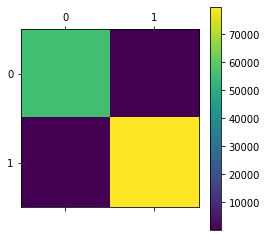

In [21]:
# confusion matrix
mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))

display(mat)
plt.matshow(mat);
plt.colorbar()
plt.show()


In [22]:
# the dectinary
FI_dic1= {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[]}
ave_FI_dic= {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[]}
targeted_Features ={0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[]}
rounds_attack_detected ={0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[]}



In [ ]:
# select aa random peer to be the scanner peer
peers_selected = random.sample(range(n_peers), number_attackers+1)
scaner = peers_selected[0]
mal = peers_selected[1 :]
if scaner == 0:
    scaner =  random.sample(range(n_peers), 1)

# Percentage and number of peers participating at each global training epoch
percentage_participants = 1.0
n_participants = int(n_peers * percentage_participants)

# the feature you want to attack in case of a poisoning attack
feature_attacked = [3,5,8]

# Number of local training epochs per global training epoch
n_local_rounds = 5

# Local batch size
local_batch_size = 32

# Local learning rate
local_lr = 0.001

# Global learning rate or 'gain'
model_substitution_rate = 1.0

# Attack detection / prevention mechanism = {None, 'distance', 'median', 'accuracy', 'krum'}
discard_outliers = None

# Used in 'dist' attack detection, defines how far the outliers are (1.5 is a typical value)
tau = 1.5

# Used in 'accuracy' attack detection, defines the error margin for the accuracy improvement
sensitivity = 0.05

# Used in 'krum' attack detection, defines how many byzantine attackers we want to defend against
tolerance=4

# Prevent suspicious peers from participating again, only valid for 'dist' and 'accuracy'
ban_malicious = False

# Clear nans and infinites in model updates
clear_nans = True

number_for_threshold1 = numpy.empty(20, dtype=float)
number_for_threshold2 = numpy.empty(20, dtype=float)
for r in range(len(number_for_threshold1)):
    number_for_threshold1[r] = 0
    number_for_threshold2[r] = 0

########################
# ATTACK CONFIGURATION #
########################

# Percentage of malicious peers
r_malicious_peers = 0.0

# Number of malicious peers (absolute or relative to total number of peers)
n_malicious_peers = int(n_peers * r_malicious_peers)
#n_malicious_peers = 1

# Malicious peers
malicious_peer = range(n_malicious_peers)

# Target for coalitions
common_attack_target = [4,7]

# Target class of the attack, per each malicious peer
malicious_targets = dict([(p, t) for p,t in zip(malicious_peer, [common_attack_target]*n_malicious_peers)])

# Boosting parameter per each malicious peer
common_malicious_boost = 12
malicious_boost = dict([(p, b) for p,b in zip(malicious_peer, [common_malicious_boost]*n_malicious_peers)])

###########
# METRICS #
###########
metrics = {'accuracy': [],
          'atk_effectivity': [],
          'update_distances': [],
          'outliers_detected': [],

          'acc_no_target': []}

####################################
# MODEL AND NETWORK INITIALIZATION #
####################################
inputs = X_train[0*ss:0*ss+ss]
outputs = y_train[0*ss:0*ss+ss]
global_model = build_model(inputs,outputs)
n_layers = len(trainable_layers(global_model))

print('Initializing network.')
sleep(1)
network = []
for i in tqdm(range(n_peers)):
    ss = int(len(X_train)/n_peers)
    inputs = X_train[i*ss:i*ss+ss]
    outputs = y_train[i*ss:i*ss+ss]
#     network.append(build_model(inputs, outputs))
    network.append(global_model)


banned_peers = set()

##################
# BEGIN TRAINING #
##################
for t in range(n_rounds):
    print(f'Round {t+1}.')
    sleep(1)

    ## SERVER SIDE #################################################################
    # Fetch global model parameters
    global_weights, global_biases = get_parameters(global_model)

    if clear_nans:
        global_weights, global_biases = nans_to_zero(global_weights, global_biases)

    # Initialize peer update lists
    network_weight_updates = []
    network_bias_updates = []

    # Selection of participant peers in this global training epoch
    if ban_malicious:
        good_peers = list([p for i,p in enumerate(network) if i not in banned_peers])
        n_participants = n_participants if n_participants <= len(good_peers) else int(len(good_peers) * percentage_participants)
        participants = random.sample(list(enumerate(good_peers)), n_participants)
    else:
        participants = random.sample(list(enumerate(network)),n_participants)
    ################################################################################


    ## CLIENT SIDE #################################################################
    for i, local_model in tqdm(participants):

        # Update local model with global parameters 
        set_parameters(local_model, global_weights, global_biases)

        # Initialization of user data
        ss = int(len(X_train)/n_peers)
        inputs = X_train[i*ss:i*ss+ss]
        outputs = y_train[i*ss:i*ss+ss]

# the scanner peer side
        if(i == scaner):
            X_train_local, X_test_local, y_train_local, y_test_local = train_test_split(inputs,outputs, test_size=0.7, random_state=rs)
            inputs = X_train_local
            outputs = y_train_local
            if(t == 0):
                forest = build_forest(X_train_local,y_train_local)
            forest_predictions = forest.predict(X_test_local)
            acc_forest = np.mean([t==p for t,p in zip(y_test_local, forest_predictions)])
            FL_predict1 = global_model.predict(X_test_local)
            imp = scan_wrong(forest_predictions, FL_predict1, forest , y_test_local, X_test_local)
            FI_dic1[t] = imp
            if t > 0:
                ave_FI_dic[t-1] = abs(FI_dic1[t] - FI_dic1[t-1])
                average_overall_changes = 0
                if t > 1:
                    for r in range(0,t):
                        average_overall_changes = average_overall_changes + ave_FI_dic[r]
                    average_overall_changes = average_overall_changes / t
                    total_Changes=0
                    average_overall_changes_one_val = 0
                    for s in range(len(ave_FI_dic[t-1])):
                        total_Changes = total_Changes + ave_FI_dic[t-1][s]
                        average_overall_changes_one_val = average_overall_changes_one_val + average_overall_changes[s]
                    print('total_Changes in this round: ', total_Changes)
                    print('average changes: ' ,average_overall_changes_one_val)
                    threshold1 = alpha * average_overall_changes_one_val
                    print(threshold1)
                    if total_Changes >= threshold1:
                        for ra in range(len(ave_FI_dic[t-1])):
                            rounds_attack_detected[t+1] = 1
                            if ave_FI_dic[t-1][ra] > beta * total_Changes:
                                print('attack have been detected')
                                targeted_Features[t+1] =names[ra]
                                print("attack detected on feature ", names[ra])
                                
                    



# atttacker peer side


        if(t+1>=start_attack_round and t+1<=end_attack_round):    
            if (i in mal):
                print("I am peer ",i,"I started the attack, at round", t+1)
                #attack
                if attack_type == 'Byzantine':
                    inputs = byzantine_attack_data(inputs)
                elif attack_type == 'poisoning':
                    inputs = poisoning_attack_data(inputs, feature_attacked)
                elif attack_type == 'label_flipping':
                    outputs = label_flipping_attack_data(outputs)

                local_weight_updates, local_bias_updates = get_updates(local_model, 
                                                                       inputs, outputs, 
                                                                       local_batch_size, n_local_rounds)
                if clear_nans:
                    local_weight_updates, local_bias_updates = nans_to_zero(local_weight_updates, local_bias_updates)



        else:
            # Benign peer
            # Train local model 
            local_weight_updates, local_bias_updates = get_updates(local_model, 
                                                                   inputs, outputs, 
                                                                   local_batch_size, n_local_rounds)
            if clear_nans:
                local_weight_updates, local_bias_updates = nans_to_zero(local_weight_updates, local_bias_updates)

        # Send updates to the server
        network_weight_updates.append(local_weight_updates)
        network_bias_updates.append(local_bias_updates)


    ## END OF CLIENT SIDE ##########################################################

    ######################################
    # SERVER SIDE AGGREGATION MECHANISMS #
    ######################################


        # Aggregate client updates
    aggregated_weights, aggregated_biases = aggregate(n_layers, 
                                                      n_participants, 
                                                      np.mean, 
                                                      network_weight_updates, 
                                                      network_bias_updates)

    if clear_nans:
        aggregated_weights, aggregated_biases = nans_to_zero(aggregated_weights, aggregated_biases)

    # Apply updates to global model
    apply_updates(global_model, model_substitution_rate, aggregated_weights, aggregated_biases)

    # Proceed as in first case
    aggregated_weights, aggregated_biases = aggregate(n_layers, 
                                                      n_participants, 
                                                      np.mean, 
                                                      network_weight_updates, 
                                                      network_bias_updates)
    if clear_nans:
        aggregated_weights, aggregated_biases = nans_to_zero(aggregated_weights, aggregated_biases)

    apply_updates(global_model, model_substitution_rate, aggregated_weights, aggregated_biases)

    ###################
    # COMPUTE METRICS #
    ###################

    # Global model accuracy
    score = global_model.evaluate(X_test, y_test, verbose=0)
    print(f'Global model loss: {score[0]}; global model accuracy: {score[1]}')
    metrics['accuracy'].append(score[1])


    # Accuracy without the target
    score = global_model.evaluate(X_test, y_test, verbose=0)
    metrics['acc_no_target'].append(score[1])


    # Distance of individual updates to the final aggregation
    metrics['update_distances'].append([dist_weights(aggregated_weights, w_i) for w_i in network_weight_updates])



Initializing network.


100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 100342.20it/s]


Round 1.


 57%|██████████████████████████████████████████████▏                                  | 57/100 [02:21<01:44,  2.44s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   12.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.4s finished
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:35<00:00,  2.75s/it]


Global model loss: 0.4784254086968245; global model accuracy: 0.8537300825119019
Round 2.


 32%|█████████████████████████▉                                                       | 32/100 [01:19<02:44,  2.42s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.5s finished
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:19<00:00,  3.79s/it]


Global model loss: 1.913670726969011; global model accuracy: 0.7795841097831726
Round 3.


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

I am peer  58 I started the attack, at round 3


  9%|███████▍                                                                          | 9/100 [00:02<00:25,  3.57it/s]

I am peer  51 I started the attack, at round 3


 23%|██████████████████▋                                                              | 23/100 [00:05<00:19,  4.01it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.4s finished


total_Changes in this round:  0.05399442952366329
average changes:  0.058936568090674844
0.0707238817088098


 35%|████████████████████████████▎                                                    | 35/100 [03:17<05:24,  4.99s/it]

I am peer  95 I started the attack, at round 3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:20<00:00,  2.00s/it]


Global model loss: 1.9800631387364644; global model accuracy: 0.6950191855430603
Round 4.


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

I am peer  58 I started the attack, at round 4


  8%|██████▌                                                                           | 8/100 [00:02<00:29,  3.17it/s]

I am peer  95 I started the attack, at round 4


 42%|██████████████████████████████████                                               | 42/100 [00:05<00:14,  4.09it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.4s finished


total_Changes in this round:  0.07331074788490739
average changes:  0.06372796135541901
0.07647355362650281


 57%|██████████████████████████████████████████████▏                                  | 57/100 [04:30<03:55,  5.48s/it]

I am peer  51 I started the attack, at round 4


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:33<00:00,  2.73s/it]


Global model loss: 0.1299796798054893; global model accuracy: 0.9635814428329468
Round 5.


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

I am peer  51 I started the attack, at round 5


 24%|███████████████████▍                                                             | 24/100 [00:02<00:08,  9.26it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.4s finished


total_Changes in this round:  0.07282977245378465
average changes:  0.06600341413001043
0.0792040969560125


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:38<00:20,  2.26it/s]

I am peer  58 I started the attack, at round 5


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:40<00:07,  2.92it/s]

I am peer  95 I started the attack, at round 5


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


Global model loss: 0.04791858909110321; global model accuracy: 0.9851178526878357
Round 6.


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

I am peer  51 I started the attack, at round 6


 49%|███████████████████████████████████████▋                                         | 49/100 [00:02<00:02, 18.14it/s]

I am peer  58 I started the attack, at round 6


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:05<00:01, 14.26it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.4s finished


total_Changes in this round:  0.047182858753608475
average changes:  0.06223930305473005
0.07468716366567606


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:21<00:05,  2.34it/s]

I am peer  95 I started the attack, at round 6


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.09it/s]


Global model loss: 0.12014329470220501; global model accuracy: 0.9583682417869568
Round 7.


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

I am peer  95 I started the attack, at round 7


  4%|███▎                                                                              | 4/100 [00:02<01:01,  1.56it/s]

I am peer  51 I started the attack, at round 7


  7%|█████▋                                                                            | 7/100 [00:05<01:05,  1.43it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.4s finished


total_Changes in this round:  0.04856604792580881
average changes:  0.059960427199909835
0.0719525126398918


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:44<00:33,  1.36it/s]

I am peer  58 I started the attack, at round 7


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.12it/s]


Global model loss: 0.06726779270004804; global model accuracy: 0.9827722907066345
Round 8.


 56%|█████████████████████████████████████████████▎                                   | 56/100 [02:20<01:47,  2.43s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.5s finished


total_Changes in this round:  0.085633505125058
average changes:  0.06362800976064527
0.07635361171277431


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:24<00:00,  2.65s/it]


Global model loss: 6.405008795226287; global model accuracy: 0.5955941677093506
Round 9.


  9%|███████▍                                                                          | 9/100 [00:22<03:47,  2.50s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.4s finished


total_Changes in this round:  0.10100569015777777
average changes:  0.06830021981028685
0.08196026377234421


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [08:34<01:26,  2.61s/it]

In [ ]:
# sort the feature according to the last epoch and print it with importances

sort_index = np.argsort(FI_dic1[9])
for x in sort_index:
    print(names[x], ', ', FI_dic1[9][x])